In [1]:
import requests
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier as KNN_Class
from sklearn.metrics import classification_report as rep
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KNeighborsRegressor as KNN_Reg

import warnings
warnings.simplefilter(action='ignore')

In [2]:
url = "https://raw.githubusercontent.com/joepollastrini/Loan-Prediction/master"
train_name = 'train_loan_data.csv'
test_name = 'test_loan_data.csv'

In [3]:
def data_grab_online(base, name, out='output.csv'):
    #get data from url
    u = base + '/' + name
    r = requests.get(u).content
    df = pd.read_csv(u)
    return df

In [4]:
train = data_grab_online(url, train_name)
test = data_grab_online(url, test_name)

Clean like normal, don't clean anything that mode was used as imputation.  If any feature engineering was used from these imputed variables.  Keep them out until imputed.

In [5]:
def gender_impute_and_dummy(row):
    #if unmarried and 1 dependent female, else male
    if pd.isnull(row['Gender']):
        if row['Married'] == 'No' and row['Dependents'] == '1':
            return 0
        else:
            return 1
    else:
        if row['Gender'] == 'Male':
            return 1
        else:
            return 0
        
train['Male_IO'] = train.apply(lambda x: gender_impute_and_dummy(x), axis=1)
train.drop(columns = ['Gender'], inplace=True)

test['Male_IO'] = test.apply(lambda x: gender_impute_and_dummy(x), axis=1)
test.drop(columns = ['Gender'], inplace = True)

In [6]:
def married_impute_and_dummy(x):
    #if female, not married, otherwise married
    if pd.isnull(x['Married']):
        if x['Male_IO'] == 0:
            return 0
        else:
            return 1
    else:
        if x['Married'] == 'Yes':
            return 1
        else:
            return 0
        
train['Married_IO'] = train.apply(lambda x: married_impute_and_dummy(x), axis=1)
train.drop(columns = ['Married'], inplace=True)

test['Married_IO'] = test.apply(lambda x: married_impute_and_dummy(x), axis=1)
test.drop(columns = ['Married'], inplace = True)

In [7]:
def dependents_impute_and_ordinal(x):
    #if married, one dependent, otherwise none
    #convert dependents to ordinal int as well
    if pd.isnull(x['Dependents']):
        if x['Married_IO'] == 1:
            return 1
        else:
            return 0
    elif x['Dependents'] == '3+':
        return 3
    else:
        return int(x['Dependents'])
    
    
train['Dependents_Ord'] = train.apply(lambda x: dependents_impute_and_ordinal(x), axis=1)
train.drop(columns = ['Dependents'], inplace=True)

test['Dependents_Ord'] = test.apply(lambda x: dependents_impute_and_ordinal(x), axis=1)
test.drop(columns = ['Dependents'], inplace = True)

In [8]:
def dual_income_dummy(x):
    if x['Married_IO'] == 1:
        if x['CoapplicantIncome'] > 0:
            return 1
        else:
            return 0
    else:
        return 0

In [9]:
def clean(df):
    col_drop = []
    col_rename = {}
    
    # FAMILY SIZE #
    df['FamilySize'] = df['Dependents_Ord'] + df['Married_IO'] + 1
        
    # EDUCATION #
    df['Education_IO'] = df['Education'].apply(lambda x: 1 if x == 'Graduate' else 0)
    col_drop.append('Education')

    # INCOME #
    df['FamilyIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['DualIncome_IO'] = df.apply(lambda x: dual_income_dummy(x), axis=1)
    col_drop.extend(['ApplicantIncome', 'CoapplicantIncome'])
    
    # PROPERTY AREA #
    df['PA_Urban'] = df['Property_Area'].apply(lambda x: 1 if x == 'Urban' else 0)
    df['PA_Rural'] = df['Property_Area'].apply(lambda x: 1 if x == 'Rural' else 0)
    df['PA_Semiurban'] = df['Property_Area'].apply(lambda x: 1 if x == 'Semiurban' else 0)
    col_drop.append('Property_Area')
    
    # INCOME PER FAMILY MEMBER #
    df['IncomePerMember'] = df['FamilyIncome'] / df['FamilySize']
    
    #column cleaning
    df.drop(columns = col_drop, inplace=True)
    df.rename(columns=col_rename, inplace=True)
    return df

In [10]:
train_clean = clean(train)
test_clean = clean(test)

Build Loan Term Amount model and use to impute

In [11]:
def loan_group(x):
    if np.isnan(x):
        return x
    else:
        x = int(x)
        if x == 360:
            return '30'
        elif x == 180:
            return '15'
        elif x < 180:
            return '<15'
        elif x > 180 and x < 360:
            return '(15, 30)'
        elif x > 360:
            return '>30'
        else:
            return x

In [12]:
def knn_model(train, x_cols, y, k, type='class'):
    if type=='class':
        model = KNN_Class(n_neighbors = k)
    else:
        model = KNN_Reg(n_neighbors = k)
        
    x = train[x_cols]
    
    model.fit(x, train[y])
    return model

In [13]:
def predict_func(model, row, x_cols):
    valueList = []
    for col in x_cols:
        value = row[col]
        valueList.append(value)

    df = pd.DataFrame([valueList])
    
    prediction = model.predict(df)[0]
    return prediction

In [14]:
def clean2(df, model, cols):
    #group loan terms, don't change nan values
    df['LoanTermGroups'] = df['Loan_Amount_Term'].apply(lambda x: loan_group(x))
    
    #create predictions using model
    df['LTA_Predict'] = df.apply(lambda x: predict_func(model, x, cols), axis=1)
    
    #replace missing values from loan term groups with predicted values
    df['LoanTermGroups'].fillna(df['LTA_Predict'], inplace=True)
    
    df.drop(columns = ['Loan_Amount_Term', 'LTA_Predict'], inplace=True)
    return df

In [15]:
train_LTA = train_clean.dropna(subset = ['Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'])
train_LTA['LoanTermGroups'] = train_LTA['Loan_Amount_Term'].apply(lambda x: loan_group(x))

LTA_knn_cols = ['IncomePerMember', 'FamilyIncome']
LTA_k = 7

In [16]:
LTA_model = knn_model(train_LTA, LTA_knn_cols, 'LoanTermGroups', LTA_k)

In [17]:
train_clean2 = clean2(train_clean, LTA_model, LTA_knn_cols)
test_clean2 = clean2(test_clean, LTA_model, LTA_knn_cols)

Build Loan Amount model and use to impute

In [18]:
train_LA = train_clean2.dropna(subset=['Self_Employed', 'LoanAmount', 'Credit_History'])
train_LA['LoanAmountLog'] = np.log(train_LA['LoanAmount'].astype('float64'))
train_LA['LTG_<15'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '<15' else 0)
train_LA['LTG_15'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '15' else 0)
train_LA['LTG_1530'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '(15, 30)' else 0)
train_LA['LTG_30'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '30' else 0)
train_LA['LTG_>30'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '>30' else 0)

LA_knn_cols = ['FamilyIncome', 'LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30']
LA_k = 52

In [19]:
def clean3(df, model, cols):
    #convert loan amount to log
    df['LoanAmountLog'] = np.log(df['LoanAmount'].astype('float64'))
    
    #create dummy vars for loan term group
    df['LTG_<15'] = df['LoanTermGroups'].apply(lambda x: 1 if x == '<15' else 0)
    df['LTG_15'] = df['LoanTermGroups'].apply(lambda x: 1 if x == '15' else 0)
    df['LTG_1530'] = df['LoanTermGroups'].apply(lambda x: 1 if x == '(15, 30)' else 0)
    df['LTG_30'] = df['LoanTermGroups'].apply(lambda x: 1 if x == '30' else 0)
    df['LTG_>30'] = df['LoanTermGroups'].apply(lambda x: 1 if x == '>30' else 0)
    
    #predict using model
    df['LA_Predict'] = df.apply(lambda x: predict_func(model, x, cols), axis=1)
    
    #replace missing values with predicted values
    df['LoanAmountLog'].fillna(df['LA_Predict'], inplace=True)
    
    #drop original loan amount column and convert logged back to normal
    df.drop(columns=['LoanAmount', 'LA_Predict'], inplace=True)
    df['LoanAmount'] = np.exp(df['LoanAmountLog'])
    df.drop(columns=['LoanAmountLog'], inplace=True)
    
    #create debt/equity variables
    df['Debt_Equity'] = (df['LoanAmount'] * 1000) / df['FamilyIncome']
    
    return df

In [20]:
LA_model = knn_model(train_LA, LA_knn_cols, 'LoanAmountLog', LA_k, type='reg')

In [21]:
def predict_func(model, row, x_cols):
    valueList = []
    for col in x_cols:
        value = row[col]
        valueList.append(value)
    
    df = pd.DataFrame([valueList])

    prediction = model.predict(df)[0]
    return prediction

In [22]:
train_clean3 = clean3(train_clean2, LA_model, LA_knn_cols)
test_clean3 = clean3(test_clean2, LA_model, LA_knn_cols)

In [23]:
nans = train_clean3.isna().sum()
nans = nans.loc[nans > 0]
nans

Self_Employed     32
Credit_History    50
dtype: int64

***
### Self Employed Imputation

In [24]:
train_clean3['Self_Employed'].unique()

array(['No', 'Yes', nan], dtype=object)

In [25]:
train_SE = train_clean3.dropna(subset = ['Self_Employed', 'Credit_History'])
test_SE = test_clean3.dropna(subset = ['Self_Employed', 'Credit_History'])

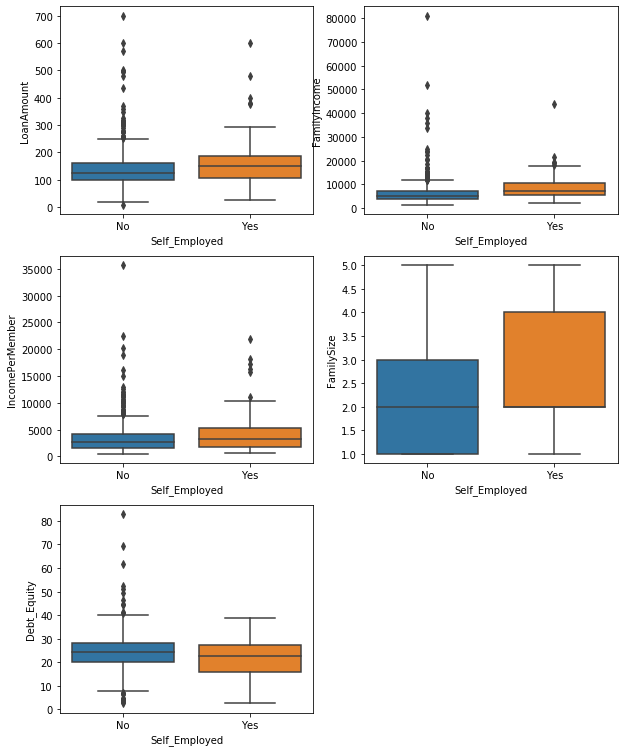

In [26]:
fig = plt.figure(figsize=(10,13))
ax1 = fig.add_subplot(3,2,1)
sns.boxplot(train_SE['Self_Employed'], train_SE['LoanAmount']);

ax2 = fig.add_subplot(3,2,2)
sns.boxplot(train_SE['Self_Employed'], train_SE['FamilyIncome']);

ax3 = fig.add_subplot(3,2,3)
sns.boxplot(train_SE['Self_Employed'], train_SE['IncomePerMember']);

ax4 = fig.add_subplot(3,2,4)
sns.boxplot(train_SE['Self_Employed'], train_SE['FamilySize']);

ax5 = fig.add_subplot(3,2,5)
sns.boxplot(train_SE['Self_Employed'], train_SE['Debt_Equity']);

In [53]:
def knn(train, test, x_cols, y, mode):
    x_train = train[x_cols]
    y_train = train[y]
    x_test = test[x_cols]
    y_test = test[y]
    
    #determine best k value
    hyperparameters = dict(n_neighbors = list(range(2,50)))
    knn_cv = KNN_Class()
    models = gscv(knn_cv, hyperparameters, cv=10)
    best_model = models.fit(x_train, y_train)
    k = best_model.best_estimator_.get_params()['n_neighbors']
    print('Optimized K:  {}'.format(k))
    
    #fit model
    model = KNN_Class(n_neighbors = k)
    model.fit(x_train, y_train)
    
    ### training set ###
    print(' *** Training ***')
    trainPreds = model.predict(x_train)
    trainPredictions = pd.DataFrame(trainPreds, columns = ['Predicted'])
    print(trainPredictions['Predicted'].value_counts())
    y_train.reset_index(drop=True, inplace=True)
    trainPredictions.reset_index(drop=True, inplace=True)
    trainAccDF = pd.concat((y_train, trainPredictions), axis=1)
    trainAccDF['Right'] = trainAccDF.apply(lambda x: 1 if x[y] == x['Predicted'] else 0, axis=1)
    trainAcc = trainAccDF['Right'].sum() / len(trainAccDF)
    print('\nTraining Accuracy:  {:.2f}%'.format(trainAcc * 100.0))
    
    trainBench = len(trainAccDF.loc[trainAccDF[y] == mode]) / len(trainAccDF)
    print('\n', 'Accuracy if selected mode ({}):  {:.2f}%'.format(mode, trainBench * 100.0))
    ### training set ###
    
    print('\n---------------------------------------------------\n')
    
    ### testing set ###
    print(' *** Testing *** ')
    testPreds = model.predict(x_test)
    testPredictions = pd.DataFrame(testPreds, columns=['Predicted'])
    print(testPredictions['Predicted'].value_counts())
    y_test.reset_index(drop=True, inplace=True)
    testPredictions.reset_index(drop=True, inplace=True)
    testAccDF = pd.concat((y_test, testPredictions), axis=1)
    testAccDF['Right'] = testAccDF.apply(lambda x: 1 if x[y] == x['Predicted'] else 0, axis=1)
    testAcc = testAccDF['Right'].sum() / len(testAccDF)
    print('Testing Accuracy:  {:.2f}%'.format(testAcc * 100.0))
    
    testBench = len(testAccDF.loc[testAccDF[y] == mode]) / len(testAccDF)
    
    print('\n', 'Accuracy if selected mode ({}):  {:.2f}%'.format(mode, testBench * 100.0))
    ### testing set ###
    
    return model

In [28]:
knn(train_SE, test_SE, ['Credit_History'], 'Self_Employed', 'No')

Optimized K:  2
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [29]:
knn(train_SE, test_SE, ['Male_IO'], 'Self_Employed', 'No')

Optimized K:  2
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [30]:
knn(train_SE, test_SE, ['Married_IO'], 'Self_Employed', 'No')

Optimized K:  4
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [31]:
knn(train_SE, test_SE, ['FamilySize'], 'Self_Employed', 'No')

Optimized K:  2
 *** Training ***
Yes    321
No     217
Name: Predicted, dtype: int64

Training Accuracy:  40.52%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
Yes    192
No     124
Name: Predicted, dtype: int64
Testing Accuracy:  41.46%

 Accuracy if selected mode (No):  88.92%


In [32]:
knn(train_SE, test_SE, ['Education_IO'], 'Self_Employed', 'No')

Optimized K:  12
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [33]:
knn(train_SE, test_SE, ['FamilyIncome'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [34]:
knn(train_SE, test_SE, ['DualIncome_IO'], 'Self_Employed', 'No')

Optimized K:  2
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [35]:
knn(train_SE, test_SE, ['PA_Urban', 'PA_Rural'], 'Self_Employed', 'No')

Optimized K:  4
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [36]:
knn(train_SE, test_SE, ['IncomePerMember'], 'Self_Employed', 'No')

Optimized K:  12
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [37]:
knn(train_SE, test_SE, ['LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30', 'LTG_>30'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [38]:
knn(train_SE, test_SE, ['Debt_Equity'], 'Self_Employed', 'No')

Optimized K:  10
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


In [39]:
knn(train_SE, test_SE, ['LoanAmount'], 'Self_Employed', 'No')

Optimized K:  8
 *** Training ***
No    538
Name: Predicted, dtype: int64

Training Accuracy:  86.06%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No    316
Name: Predicted, dtype: int64
Testing Accuracy:  88.92%

 Accuracy if selected mode (No):  88.92%


FamilyIncome is the only model that improved on the accuracy (didn't choose only No).  Look to try adding another variable, but likely won't matter.

In [40]:
knn(train_SE, test_SE, ['FamilyIncome'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [41]:
knn(train_SE, test_SE, ['FamilyIncome', 'Credit_History'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [42]:
knn(train_SE, test_SE, ['FamilyIncome', 'Male_IO'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [43]:
knn(train_SE, test_SE, ['FamilyIncome', 'Married_IO'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [44]:
knn(train_SE, test_SE, ['FamilyIncome', 'FamilySize'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [45]:
knn(train_SE, test_SE, ['FamilyIncome', 'Education_IO'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [46]:
knn(train_SE, test_SE, ['FamilyIncome', 'DualIncome_IO'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [47]:
knn(train_SE, test_SE, ['FamilyIncome', 'PA_Urban', 'PA_Rural'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [48]:
knn(train_SE, test_SE, ['FamilyIncome', 'IncomePerMember'], 'Self_Employed', 'No')

Optimized K:  11
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  86.62%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     309
Yes      7
Name: Predicted, dtype: int64
Testing Accuracy:  87.34%

 Accuracy if selected mode (No):  88.92%


Slightly worse than FamilyIncome by itself

In [49]:
knn(train_SE, test_SE, ['FamilyIncome', 'LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30', 'LTG_>30'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [50]:
knn(train_SE, test_SE, ['FamilyIncome', 'Debt_Equity'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%


In [51]:
knn(train_SE, test_SE, ['FamilyIncome', 'LoanAmount'], 'Self_Employed', 'No')

Optimized K:  9
 *** Training ***
No     514
Yes     24
Name: Predicted, dtype: int64

Training Accuracy:  86.80%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     309
Yes      7
Name: Predicted, dtype: int64
Testing Accuracy:  87.34%

 Accuracy if selected mode (No):  88.92%


Will use only FamilyIncome

In [52]:
import pickle
direct = os.getcwd()
print(direct)

C:\Users\joepo\Desktop\Project Portfolio\Loan Prediction\Credit History


In [54]:
m = knn(train_SE, test_SE, ['FamilyIncome'], 'Self_Employed', 'No')

Optimized K:  6
 *** Training ***
No     523
Yes     15
Name: Predicted, dtype: int64

Training Accuracy:  87.73%

 Accuracy if selected mode (No):  86.06%

---------------------------------------------------

 *** Testing *** 
No     312
Yes      4
Name: Predicted, dtype: int64
Testing Accuracy:  87.66%

 Accuracy if selected mode (No):  88.92%
